In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers

import time 

Using TensorFlow backend.


### Data Processing

In [2]:
df = pd.read_csv('../data/num_data.csv')

In [3]:
POLLUTION = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

In [4]:
WEATHER = ['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']

In [5]:
dataset = df[WEATHER]

In [6]:
dataset.shape

(1000, 6)

In [7]:
# Useful functions
def plot_predictions(test, predicted):
    plt.figure(figsize=(30, 15));

    plt.plot(test, color='red', alpha=0.5, label='Actual PM2.5 Concentration',)
    plt.plot(predicted, color='blue', alpha=0.5, label='Predicted PM2.5 Concentation')
    plt.title('PM2.5 Concentration Prediction')
    plt.xlabel('Time')
    plt.ylabel('PM2.5  Concentration')
    plt.legend()
    plt.show()
    

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

In [8]:
data_size = dataset.shape[0]
train_size=int(data_size * 0.6)
test_size = 100
valid_size = data_size - train_size - test_size

test_next_day = [12, 24, 48]
n_feature = dataset.shape[1]

In [9]:
training_set = dataset[:train_size].values
valid_set = dataset[train_size:train_size+valid_size].values
test_set = dataset[data_size-test_size:].values

In [10]:
y = dataset.iloc[:,0].values
y = y.reshape(-1,1)

y.shape

(1000, 1)

In [11]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
valid_set_scaled = sc.fit_transform(valid_set)
test_set_scaled = sc.fit_transform(test_set)

sc_y = MinMaxScaler(feature_range=(0,1))
y_scaled = sc_y.fit_transform(y)

In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X_, y_ = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, 0]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [13]:
n_steps_in = 24
n_steps_out = 24
X_train, y_train = split_sequences(training_set_scaled, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_set_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test_set_scaled, n_steps_in, n_steps_out)

In [14]:
GRU_reg = Sequential()
LSTM_reg = Sequential()
GRU_GRU_reg =  Sequential()
GRU_LSTM_reg = Sequential()
LSTM_GRU_reg = Sequential()
LSTM_LSTM_reg = Sequential()


GRU_reg.add(GRU(units=50, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
# The output layer
GRU_reg.add(Dense(units=n_steps_out))


LSTM_reg.add(LSTM(units=50, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
LSTM_reg.add(Dense(units=n_steps_out))


GRU_GRU_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
GRU_GRU_reg.add(GRU(units=50, activation='tanh'))
GRU_GRU_reg.add(Dense(units=n_steps_out))


LSTM_LSTM_reg.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
LSTM_LSTM_reg.add(LSTM(units=50, activation='tanh'))
LSTM_LSTM_reg.add(Dense(units=n_steps_out))


LSTM_GRU_reg.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
LSTM_GRU_reg.add(GRU(units=50, activation='tanh'))
LSTM_GRU_reg.add(Dense(units=n_steps_out))


GRU_LSTM_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
GRU_LSTM_reg.add(LSTM(units=50, activation='tanh'))
GRU_LSTM_reg.add(Dense(units=n_steps_out))


# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)

GRU_reg.compile(optimizer=adam,loss='mean_squared_error')
LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')
GRU_GRU_reg.compile(optimizer=adam,loss='mean_squared_error')
LSTM_LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')
LSTM_GRU_reg.compile(optimizer=adam,loss='mean_squared_error')
GRU_LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
DFS = Sequential()
CBGRU = Sequential()

DFS_GRU = Sequential()
CBLSTM = Sequential()

DFS_2LSTM = Sequential()
CB_2GRU = Sequential()


# filters defines how many features will be captured
# kernel size gives the size of the sliding window
DFS.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
DFS.add(MaxPooling1D(pool_size=4))
DFS.add(Dropout(0.2))  
DFS.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
DFS.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS.add(Dense(units=n_steps_out))

CBGRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
CBGRU.add(MaxPooling1D(pool_size=4))
CBGRU.add(Dropout(0.2))  
CBGRU.add(Bidirectional(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1],n_feature), activation='tanh')))
CBGRU.add(Dense(units=n_steps_out))


DFS_GRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
DFS_GRU.add(MaxPooling1D(pool_size=4))
DFS_GRU.add(Dropout(0.2))  
DFS_GRU.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
DFS_GRU.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS_GRU.add(Dense(units=n_steps_out))

CBLSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
CBLSTM.add(MaxPooling1D(pool_size=4))
CBLSTM.add(Dropout(0.2))  
CBLSTM.add(Bidirectional(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1],n_feature), activation='tanh')))
CBLSTM.add(Dense(units=n_steps_out))


DFS_2LSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
DFS_2LSTM.add(MaxPooling1D(pool_size=4))
DFS_2LSTM.add(Dropout(0.2))  
DFS_2LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
DFS_2LSTM.add(LSTM(units=50,  activation='tanh'))
DFS_2LSTM.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS_2LSTM.add(Dense(units=n_steps_out))

CB_2GRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
CB_2GRU.add(MaxPooling1D(pool_size=4))
CB_2GRU.add(Dropout(0.2))  
CB_2GRU.add(Bidirectional(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh')))
CB_2GRU.add(Bidirectional(GRU(units=50, activation='tanh')))
CB_2GRU.add(Dense(units=n_steps_out))



# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)

DFS.compile(optimizer=adam,loss='mean_squared_error')
CBGRU.compile(optimizer=adam,loss='mean_squared_error')
DFS_2LSTM.compile(optimizer=adam,loss='mean_squared_error')
CBLSTM.compile(optimizer=adam,loss='mean_squared_error')
DFS_GRU.compile(optimizer=adam,loss='mean_squared_error')
CB_2GRU.compile(optimizer=adam,loss='mean_squared_error')

In [16]:
RnnModelDict = {'LSTM': LSTM_reg, 'GRU': GRU_reg, 'LSTM_LSTM': LSTM_LSTM_reg, 'GRU_GRU': GRU_GRU_reg, 
                'LSTM_GRU': LSTM_GRU_reg, 'GRU_LSTM': GRU_LSTM_reg, 'DFS': DFS, 'CBGRU': CBGRU,
                'DFS_GRU': DFS_GRU, 'DFS_2LSTM': DFS_2LSTM, 'CB_2GRU': CB_2GRU, 'CBLSTM': CBLSTM}

X_test_24 = X_test[:24]
y_test_24 = y_test[:24]
rmse_df = pd.DataFrame(columns=['Model', 'train_rmse', 'valid_rmse', '24h_pred_rmse', 'train_time', ])


training start for LSTM_GRU

Epoch 1/2
554/554 [==============================] - 1s 2ms/step - loss: 0.0455
Epoch 2/2
554/554 [==============================] - 0s 451us/step - loss: 0.0268
results for training set


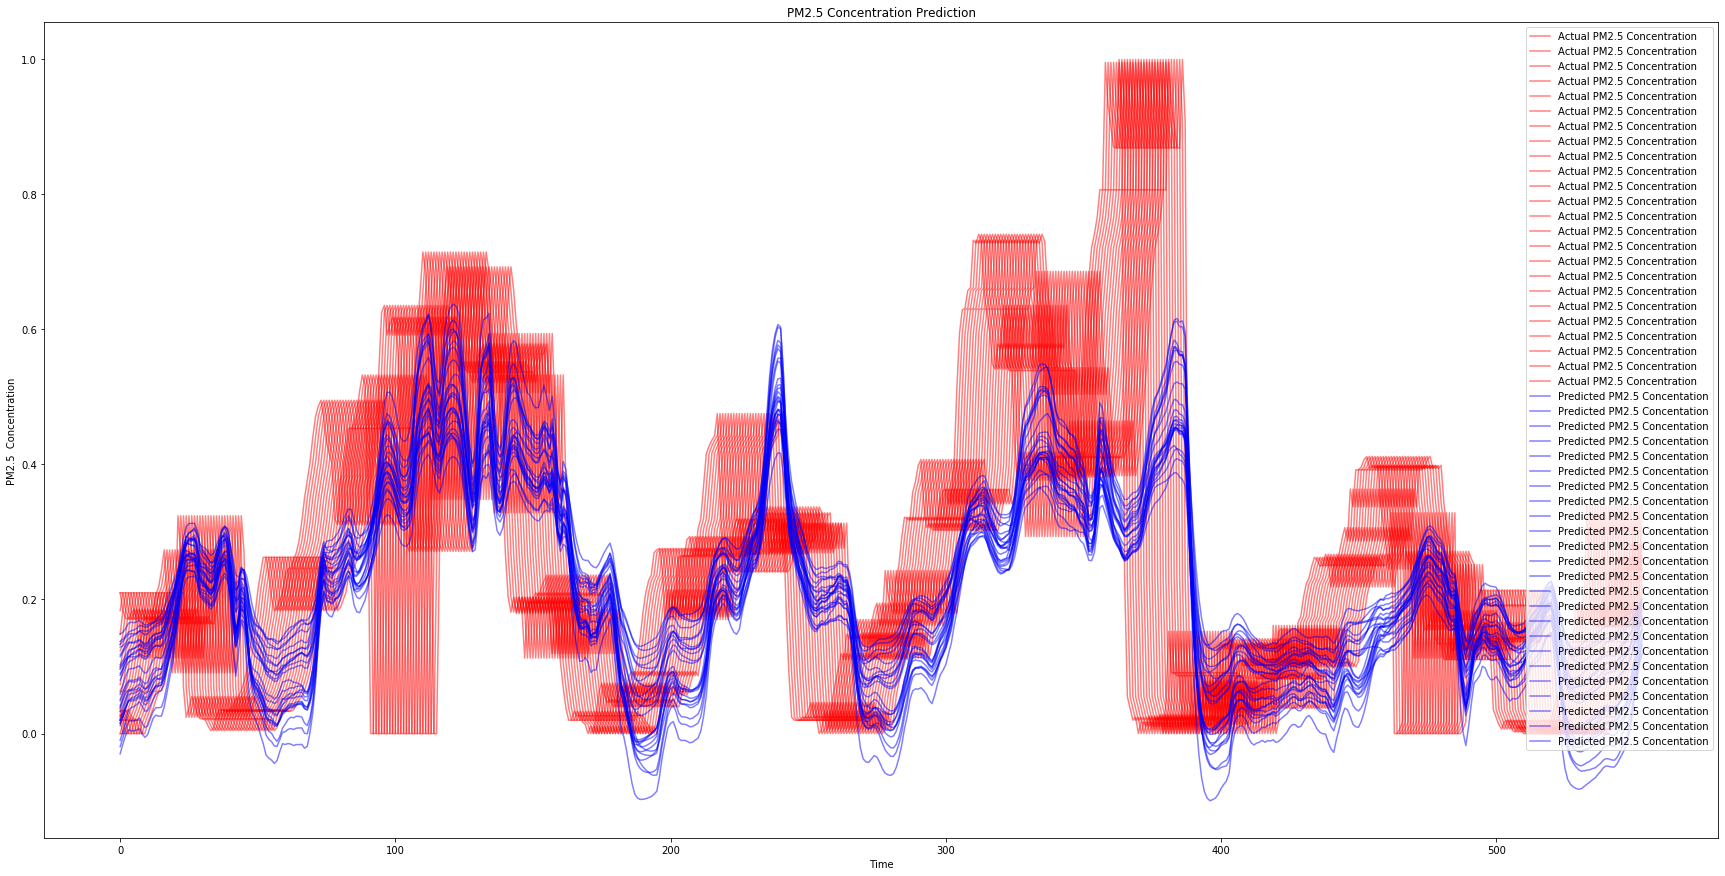

results for valid set


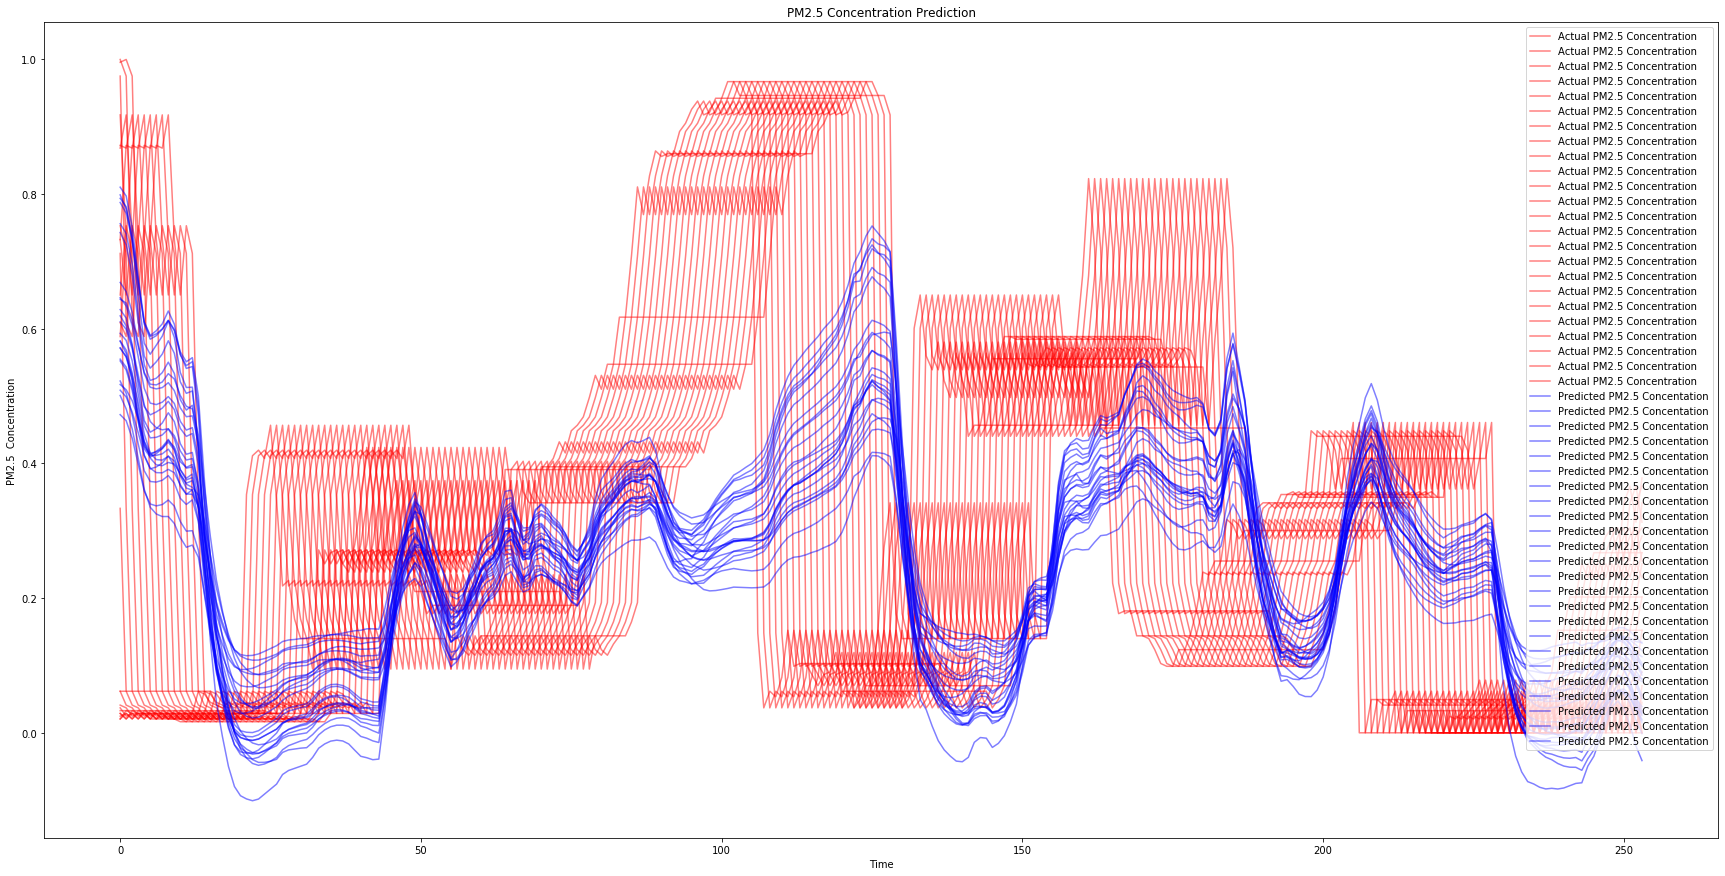

results for test set - 24 hours


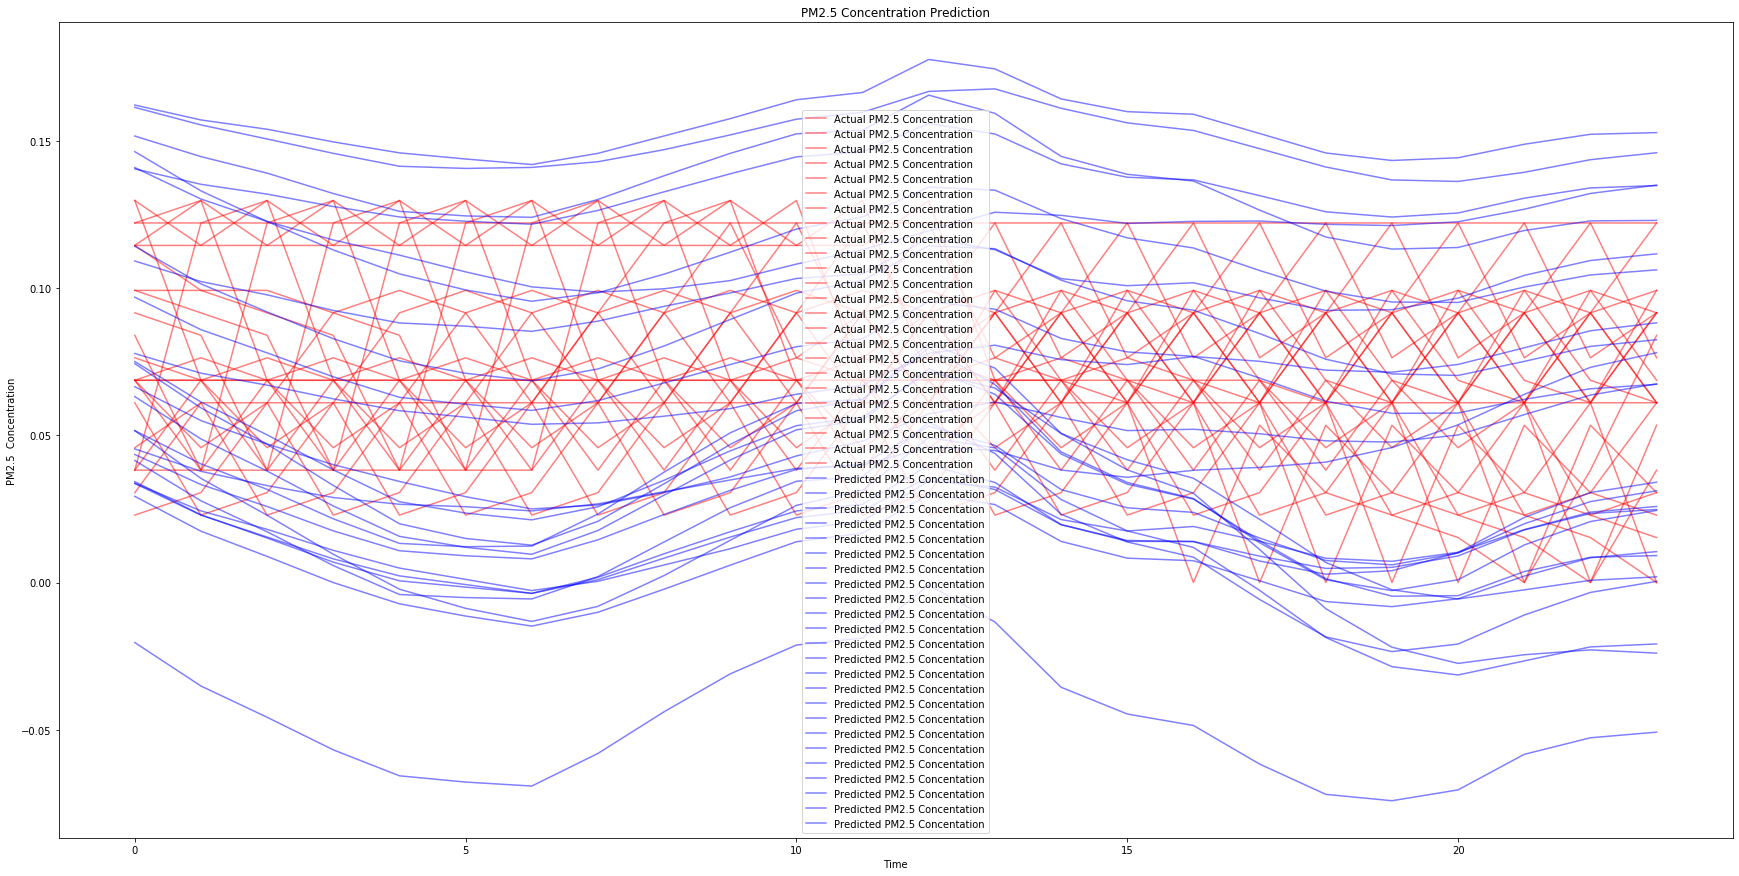

In [17]:
for model in RnnModelDict:
    regressor = RnnModelDict[model]
    
    print('training start for', model)    
    start = time.process_time()
    regressor.fit(X_train,y_train,epochs=50,batch_size=32)
    train_time = round(time.process_time() - start, 2)
    
    print('results for training set')
    y_train_pred = regressor.predict(X_train)
    plot_predictions(y_train,y_train_pred)
    train_rmse = return_rmse(y_train,y_train_pred)
    
    print('results for valid set')
    y_valid_pred = regressor.predict(X_valid)
    plot_predictions(y_valid,y_valid_pred)
    valid_rmse = return_rmse(y_valid,y_valid_pred)
    
    
    print('results for test set - 24 hours')
    y_test_pred24 = regressor.predict(X_test_24)
    plot_predictions(y_test_24,y_test_pred24)
    test24_rmse = return_rmse(y_test_24,y_test_pred24)
    
    
    one_df = pd.DataFrame([[model, train_rmse, valid_rmse, test24_rmse, train_time]], 
                          columns=['Model', 'train_rmse', 'valid_rmse', '24h_pred_rmse', 'train_time'])
    rmse_df = pd.concat([rmse_df, one_df])

# save the rmse results 
rmse_df.to_csv('../rmse_result_all_v1.csv')


Train on 554 samples, validate on 254 samples
Epoch 1/5
 - 0s - loss: 0.0116 - val_loss: 0.0710
Epoch 2/5
 - 0s - loss: 0.0204 - val_loss: 0.0605
Epoch 3/5
 - 0s - loss: 0.0144 - val_loss: 0.0623
Epoch 4/5
 - 0s - loss: 0.0104 - val_loss: 0.0696
Epoch 5/5
 - 0s - loss: 0.0107 - val_loss: 0.0590


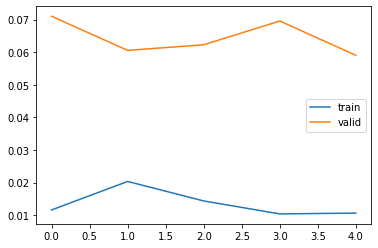

In [19]:
history = regressor.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_valid, y_valid),
                        verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

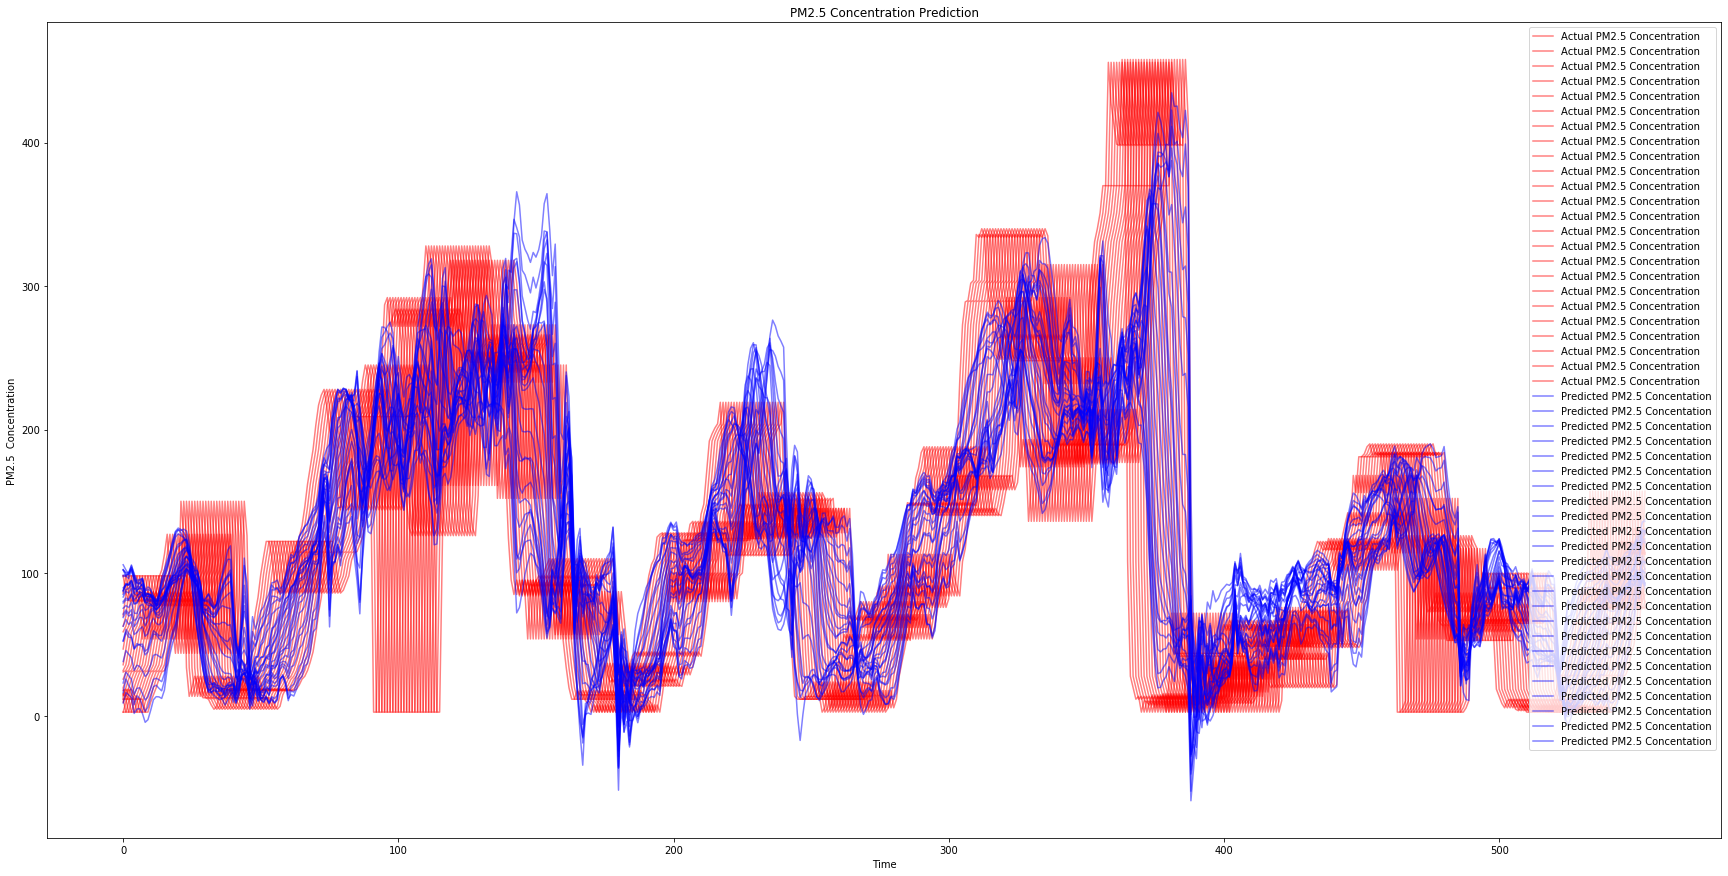

44.046455275885755

In [20]:
# Transform back and plot
y_train_origin = y_train
y_train_origin = sc_y.inverse_transform(y_train_origin)

y_train_pred = regressor.predict(X_train)
y_train_pred_origin = sc_y.inverse_transform(y_train_pred)

plot_predictions(y_train_origin,y_train_pred_origin)
return_rmse(y_train_origin,y_train_pred_origin)

array([[ 16.,  14.,  18., ...,  86.,  98.,  98.],
       [ 14.,  18.,  19., ...,  98.,  98.,  86.],
       [ 18.,  19.,  15., ...,  98.,  86.,  81.],
       ...,
       [ 65.,  89.,  80., ..., 131., 128., 113.],
       [ 89.,  80.,  85., ..., 128., 113., 123.],
       [ 80.,  85.,  98., ..., 113., 123., 128.]])